### EE 421/521 Image Processing - Spring 2021-22

## Project 7 - Geometric Transformations

#### Submission deadline: 7 April 2022

In this project, you will implement the following:

1. Calculate affine mapping parameters between two triangles
2. Geometrically transform an image into a trapezoid shape using two affine mappings 

**This project will be graded for both EE 421 (HW6) and EE 521 (HW6) students.**

*Copyright (c) 2020-2022 by Arif Tanju Erdem*

************************************
***Metin Arda Köker***
************************************

In [1]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib as mpl
import matplotlib.pyplot as plt

# array operations
import numpy as np

# signal processing operations
from scipy import signal

# mathematical calculations
import math

In [2]:
# display an image in original size (new version)
# from: https://stackoverflow.com/questions/28816046/
# displaying-different-images-with-actual-size-in-matplotlib-subplot

def my_display_actual_size(img, str_caption):
    
    dpi = mpl.rcParams['figure.dpi']
    height, width = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    # ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')

    plt.title(str_caption)
    plt.show()

    return

# end of function

In [3]:
# my function for bilinear interpolation

def my_BilinearInterp(img, x, y):
    
    # find the four nearest integer locations
    xL = int(math.floor(x))
    xH = int(math.ceil(x))
    yL = int(math.floor(y))
    yH = int(math.ceil(y))
    
    # get the four nearest pixel values
    A = img[yL,xL]  
    B = img[yL,xH]  
    C = img[yH,xL]  
    D = img[yH,xH]  

    # calculate the delta values
    dx = x - xL
    dy = y - yL

    # calculate the interpolated image value
    valInterp = (1-dy) * ((1-dx)*A + dx*B) + dy * ((1-dx)*C + dx*D)
    
    return valInterp

# end of function

In [4]:
# my function for image warping using a 3x3 geometric transformation matrix

def my_warpImage(imgSource, matForward, isBackwardMapping, interpType = 'Nearest'):
    
    # get image dimensions
    srcHeight, srcWidth = imgSource.shape
    
    assert matForward.shape == (3,3)
    
    # determine source image center
    srcCenterX = srcWidth//2
    srcCenterY = srcHeight//2

    # UL: upper-left corner, UR: upper-right corner
    # LL: lower-left corner, UR: lower-right corner
    srcCornerUL = np.array([-srcCenterX, srcCenterY, 1])
    srcCornerUR = np.array([ srcCenterX, srcCenterY, 1])
    srcCornerLL = np.array([-srcCenterX,-srcCenterY, 1])
    srcCornerLR = np.array([ srcCenterX,-srcCenterY, 1])
    
    # transform the corners
    trgCornerUL = np.dot(matForward,srcCornerUL)
    trgCornerUR = np.dot(matForward,srcCornerUR)
    trgCornerLL = np.dot(matForward,srcCornerLL)
    trgCornerLR = np.dot(matForward,srcCornerLR)
    
    # find minimum & maximum x & y values
    minX = int(round(min(trgCornerUL[0], trgCornerUR[0], trgCornerLL[0], trgCornerLR[0]),0))
    maxX = int(round(max(trgCornerUL[0], trgCornerUR[0], trgCornerLL[0], trgCornerLR[0]),0))
    minY = int(round(min(trgCornerUL[1], trgCornerUR[1], trgCornerLL[1], trgCornerLR[1]),0))
    maxY = int(round(max(trgCornerUL[1], trgCornerUR[1], trgCornerLL[1], trgCornerLR[1]),0))
    
    # determine target image area
    trgWidth = maxX - minX + 1
    trgHeight = maxY - minY + 1
    
    # pick a bigger image size to account for translation
    shiftX = int(matForward[0,2])
    shiftY = int(matForward[1,2])
    trgWidth += abs(shiftX)
    trgHeight += abs(shiftY)

    # determine the target image center    
    trgCenterX = trgWidth//2
    trgCenterY = trgHeight//2

    # create target image array
    imgTarget = np.zeros((trgHeight, trgWidth))
    
    if isBackwardMapping == False: # forward mapping
        
        # map source pixels into target image using FORWARD mapping
        # start with the top-most row
        srcY = srcCenterY
        for row in imgSource:
            # start with the left-most pixel on the current row
            srcX = -srcCenterX
            for pixel in row:
                # set pixel location
                srcPixel = np.array([srcX, srcY, 1])
                # map the pixel location to the target image
                trgPixel = np.dot(matForward, srcPixel)
                # shift by the center and flip the y axis to find actual pixel location
                # round the location to integer to find the nearest pixel location in the target image
                trgX = int(np.round(trgPixel[0]+trgCenterX-shiftX//2,0))
                trgY = int(np.round(trgPixel[1]+trgCenterY-shiftY//2,0))
                trgY = trgHeight - trgY
                # if within bounds assign values
                if trgY < trgHeight and trgY >= 0 and trgX < trgWidth and trgX >= 0:
                    # assign the target pixel value
                    imgTarget[trgY,trgX] = pixel

                # move to the next pixel to the right
                srcX += 1

            # move to the next row below
            srcY -= 1
            
        # end of loop
            
    else: # backward mapping
        
        # find backward mapping matrix by taking inverse of the forward mapping
        matBackward = np.linalg.inv(matForward)

        # map source pixels into target image using BACKWARD mapping
        # start with the top-most row
        trgY = trgCenterY
        for n in range(trgHeight):
            # start with the left-most pixel on the current row
            trgX = -trgCenterX
            for m in range(trgWidth):
                # set pixel location
                trgPixel = np.array([trgX+shiftX//2, trgY+shiftY//2, 1])
                # map the pixel location to source image
                srcPixel = np.dot(matBackward, trgPixel)
                # shift by the center and flip the y axis to find actual pixel location
                srcXfloat = srcPixel[0]+srcCenterX
                srcYfloat = srcPixel[1]+srcCenterY
                srcYfloat = srcHeight - srcYfloat

                # find nearest integer location
                srcX = int(round(srcXfloat,0))
                srcY = int(round(srcYfloat,0))
                # check if source location is within image bounds
                # use a 1 pixel marging for bilinear mapping
                if srcY < srcHeight-1 and srcY > 0 and srcX < srcWidth-1 and srcX > 0:
                    # assign the target pixel value
                    if interpType == 'Bilinear':
                        imgTarget[n,m] = my_BilinearInterp(imgSource, srcXfloat, srcYfloat)
                    else: #default is NearestNeighbor
                        imgTarget[n,m] = imgSource[srcY,srcX]
                        
                # move to the next pixel to the right
                trgX += 1

            # move to the next row below
            trgY -= 1
            
        # end of loop

    return imgTarget

# end of my function

In [5]:
# STEP 1. Find affine mapping parameters between two triangular regions

# source triangle's A, B, C corners
srcTriangle = ((0.0, 0.0), (2.0, 0.0), (1.0, 1.0))
# target triangle's A, B, C corners
trgTriangle = ((1.0, 0.0), (3.0, 1.0), (2.0, 3.0))

#---------------------------------------------------------------
# Calculate and print the affine matrix for backward mapping (from target triangle to source triangle)
#---------------------------------------------------------------

# ADD YOUR CODE HERE
SourceImageCoor = ((0,0,1,0,0,0),
                   (0,0,0,0,0,1),
                   (2,0,1,0,0,0),
                   (0,0,0,2,0,1),
                   (1,1,1,0,0,0),
                   (0,0,0,1,1,1))
Sourcenp = np.array(SourceImageCoor)
Targetnp = np.array([1,0,3,1,2,3])
Targetnp=Targetnp.reshape(6,1)
#print(Sourcenp,Sourcenp.shape)
#print(Targetnp,Targetnp.shape)

# matAffineBack = ...
SourceInv=np.linalg.inv(Sourcenp)
#print(SourceInv,Sourcenp.shape)
matAffineBack=np.matmul(SourceInv,Targetnp)
# print matAffineBack ...
print(matAffineBack)

[[1. ]
 [0. ]
 [1. ]
 [0.5]
 [2.5]
 [0. ]]


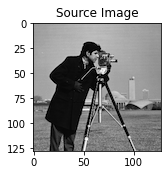

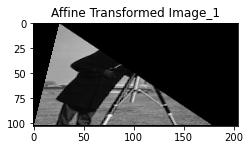

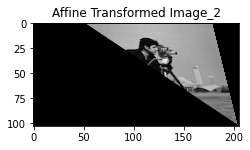

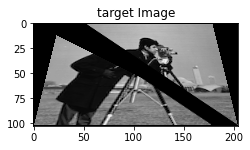

In [29]:
# STEP 2. Divide an image into two triangles and map its content with two affine mappings

# set image folder
image_folder = r'C:\Users\Metin\Desktop\EE421\Week7'


# read input image 
image_file = r'/cameraman_128.tiff'
image_path = image_folder + image_file
imgSource = io.imread(image_path)

if imgSource.ndim == 3:
    # calculate the luminance image
    img = my_imgLuminance(imgSource)
else:
    img = imgSource

# get image width and height
height, width = imgSource.shape

# define source & target image support
srcQuad = ((0.0, 0.0), (width, 0.0), (width, height), (0.0, height))
trgQuad = ((0.0, 0.0), (width*1.4, 0.0), (width*1.2, height*0.8), (width*0.2, height*0.8))
#---------------------------------------------------------------
# Calculate and print the two affine matrices from target image to source image
#---------------------------------------------------------------
srcTriangle_Mat1 = np.array([[srcQuad[0][0], srcQuad[0][1], 1.0, 0.0, 0.0, 0.0], 
                     [0.0, 0.0, 0.0, srcQuad[0][0], srcQuad[0][1], 1.0],
                     [srcQuad[1][0], srcQuad[1][1], 1.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, srcQuad[1][0], srcQuad[1][1], 1.0],
                     [srcQuad[3][0], srcQuad[3][1], 1.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, srcQuad[3][0], srcQuad[3][1], 1.0]])
srcTriangle_Mat2 = np.array([[srcQuad[1][0], srcQuad[1][1], 1.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, srcQuad[1][0], srcQuad[1][1], 1.0],
                     [srcQuad[2][0], srcQuad[2][1], 1.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, srcQuad[2][0], srcQuad[2][1], 1.0],
                     [srcQuad[3][0], srcQuad[3][1], 1.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, srcQuad[3][0], srcQuad[3][1], 1.0]])
# ADD YOUR CODE HERE
trgTriangle_Mat1 = np.array([trgQuad[0][0],trgQuad[0][1],trgQuad[1][0],trgQuad[1][1],trgQuad[3][0],trgQuad[3][1]])

trgTriangle_Mat2 = np.array([trgQuad[1][0],trgQuad[1][1],trgQuad[2][0],trgQuad[2][1],trgQuad[3][0],trgQuad[3][1]])

# matAffineBack_1 = ...
# matAffineBack_2 = ...
matAffineBack_1 = np.linalg.inv(srcTriangle_Mat1)
matAffineBack_1 = np.matmul(matAffineBack_1, trgTriangle_Mat1)
                           
matAffineBack_2 = np.linalg.inv(srcTriangle_Mat2)
matAffineBack_2 = np.matmul(matAffineBack_2, trgTriangle_Mat2)
# print matAffineBack_1 ...
# print matAffineBack_2 ...

#---------------------------------------------------------------
# Obtain the affine mapped image using backward mapping and bilinear interpolation
#---------------------------------------------------------------
matTrans_1 = np.array([[matAffineBack_1.item(0),matAffineBack_1.item(1),matAffineBack_1.item(2)],
                      [matAffineBack_1.item(3),matAffineBack_1.item(4),matAffineBack_1.item(5)],
                      [0.0, 0.0,1.0]])
matTrans_2 = np.array([[matAffineBack_2.item(0),matAffineBack_2.item(1),matAffineBack_2.item(2)],
                      [matAffineBack_2.item(3),matAffineBack_2.item(4),matAffineBack_2.item(5)],
                      [0.0, 0.0,1.0]])
#ADD YOUR CODE HERE

# imgTarget = ...
upper_triangle=np.copy(imgSource)
upper_triangle=np.triu(upper_triangle)
#my_display_actual_size(upper_triangle,'Upper triangle of Source Image')

lower_triangle=np.copy(imgSource)
lower_triangle=np.tril(lower_triangle)
#my_display_actual_size(lower_triangle,'Lower triangle of Source Image')
# display imgSource & imgTarget ...
imgTarget_aff_1 = my_warpImage(lower_triangle, matTrans_1, True, 'Bilinear')
imgTarget_aff_2 = my_warpImage(upper_triangle, matTrans_2, True, 'Bilinear')

my_display_actual_size(imgSource,'Source Image')

my_display_actual_size(imgTarget_aff_1,'Affine Transformed Image_1')
my_display_actual_size(imgTarget_aff_2,'Affine Transformed Image_2')

target= np.zeros((103, 205))
height,width = target.shape

for x in range(height):
    for y in range(205):
        if(y < 2*x):
            target[x][y] = imgTarget_aff_1[x][y]
        else:
            target[x][y] = imgTarget_aff_2[x][y]
my_display_actual_size(target,'target Image')

*STEP 3 Comments on the results*

*ADD YOUR COMMENTS HERE*

Comment on the effect of using two affine mappings to warp an image in STEP 2.

Wheter than using 2 triangle theorem using quadrant changing theorem can be more easy. The triangle combining part is hard to understand and process.